In [ ]:
# default_exp tbptt
# default_cls_lvl 3

In [ ]:
#hide
%matplotlib notebook
from fastai2.callback.progress import *
from fastai2.callback.tracker import *
from fastai2.callback.schedule import *

In [ ]:
#export
from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from fastai2.basics import *

import math

## TBPTT Dataloader
> Pytorch Modules for Training Models for sequential data

The tbptt dataloader needs to split the minibatches that are created in several smaller minibatches that will be returned sequentially before the next minibatch may be created.

In [ ]:
#export
@delegates()
class TbpttDl(TfmdDL):

    def __init__(self, dataset, sub_seq_len=None, seq_len = None ,shuffle=True,num_workers=0, **kwargs):
        self.n_sub_seq = None
        super().__init__(dataset=dataset, shuffle=shuffle, num_workers=num_workers, **kwargs)
        store_attr(self,'sub_seq_len')
        
        if sub_seq_len is not None: 
            if seq_len is None: seq_len = self.do_item(0)[0].shape[0]
            self.n_sub_seq = math.ceil(seq_len / sub_seq_len)
  
        self.rnn_reset = self.n_sub_seq is None #always reset stateful rnns if there are no subsequences
        
    def __len__(self):
        if self.n_sub_seq is None:
            return super().__len__()
        else:
            return super().__len__()*self.n_sub_seq
    
    def create_batches(self, samps):
        batch_iter = super().create_batches(samps)
        if self.n_sub_seq is None:
            return batch_iter
        else:
            return self._tbptt_generator(batch_iter)
        
    def _tbptt_generator(self,batch_iter):
        for b in batch_iter:
            tmp_b = b
            for i in range(self.n_sub_seq):
                self.rnn_reset = i == 0
                #it is importan to retain the tuple type, or future transforms may now work
                trunc_b = tuple([retain_type(x[:,i*self.sub_seq_len:(i+1)*self.sub_seq_len],x) for x in b])
                yield trunc_b

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,clm_shift=[-1,-1]),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput,clm_shift=[1])),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=1000+1,stp_sz=100,clm='current')]),
                 splitter=ApplyToDict(ParentSplitter()))
db = seq.dataloaders(get_hdf_files('test_data/'),dl_type=TbpttDl,sub_seq_len=200)

In [ ]:
db.train.one_batch()[0].shape,db.valid.one_batch()[0].shape

(torch.Size([64, 200, 2]), torch.Size([64, 1000, 2]))

num_workers has to be 0. If there are parallel workers, the order of minibatches will be corrupted

## TBPTT_Reset_Callback
The stateful model needs to reset its hidden state, when a new sequence begins. The callback reads the reset flag and acts accordingly.

In [ ]:
#export
class TbpttResetCB(Callback):
    "`Callback` resets the rnn model with every new sequence for tbptt"
        
    def begin_batch(self):
        dl = self.learn.dls.train if self.training else self.learn.dls.valid
#         if not self.training: import pdb; pdb.set_trace()
        if hasattr(dl,'rnn_reset')and dl.rnn_reset: self.model.reset()

## Example

In [ ]:
lrn = RNNLearner(db,num_layers=1,rnn_type='gru',stateful=False,metrics=[SkipNLoss(fun_rmse,100)])
lrn.add_cb(TbpttResetCB())

<IPython.core.display.Javascript object>


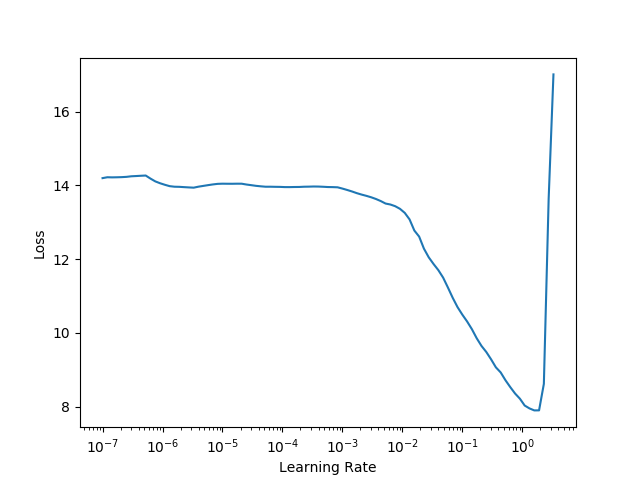

(0.15848932266235352, 0.019054606556892395)

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(1,lr_max=3e-2)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.027839,0.004647,0.007074,00:20


In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_model.ipynb.
Converted 02_learner.ipynb.
Converted 03_tbptt_dl.ipynb.
Converted 11_ProDiag.ipynb.
Converted 12_TensorQuaternions.ipynb.
Converted 13_PBT.ipynb.
Converted index.ipynb.
